In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Set up environment & libraries, load data

In [0]:
!pip install matplotlib==3.1.0

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec, Phrases
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import pickle
%matplotlib inline

Using TensorFlow backend.


In [0]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (8, 6),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [0]:
def plot_confusion_matrix(cm):
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, cmap='Blues',ax = ax,fmt='g',annot_kws={"size": 20})
  ax.set_xlabel('Predict')
  ax.set_ylabel('Actual') 
  ax.yaxis.set_ticklabels(['Positive', 'Negative'], rotation = 0)
  ax.xaxis.set_ticklabels(['Positive', 'Negative'])

In [0]:
train = pd.read_csv('drive/My Drive/data/train.csv',sep='|')
X_train = train['text']
y_train = train['sentiment']

In [0]:
test = pd.read_csv('drive/My Drive/data/test2.csv',sep='|')
X_test = test['text']
y_test = test['sentiment']

## Bag of words model

Vectorize train with CountVectorizer:

In [0]:
%%time
cv = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,3))
X_train = cv.fit_transform(X_train)

CPU times: user 3min 44s, sys: 3.22 s, total: 3min 47s
Wall time: 3min 47s


Transform train and test data with said vectorizer

In [0]:
%%time
X_test = cv.transform(X_test)
print('Bag of words train:', X_train.shape)
print('Bag of words test:', X_test.shape)

Bag of words train: (300000, 14824214)
Bag of words test: (49000, 14824214)
CPU times: user 10.5 s, sys: 2.73 ms, total: 10.5 s
Wall time: 10.5 s


### Logistic Regression

In [0]:
Cs = [float("1e%d" %i) for i in range(-8,1)]
train_results = []
test_results = []
y_preds = []
for c in Cs:
  lr = LogisticRegression(C=c,max_iter=100,random_state=42,verbose=3)
  lr.fit(X_train,y_train)
  train_results.append(lr.score(X_train,y_train))
  y_preds.append(lr.predict(X_test))
  test_results.append(lr.score(X_test,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

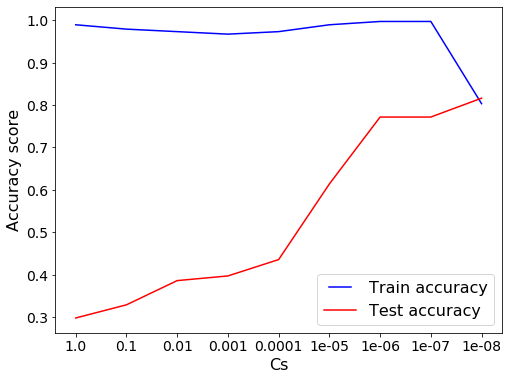

In [0]:
a = np.arange(len(Cs))
line1, = plt.plot(a, train_results, 'b', label='Train accuracy')
line2, = plt.plot(a, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax = plt.gca()
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(Cs)
ax.invert_xaxis()
plt.ylabel('Accuracy score')
plt.xlabel('Cs')
plt.show()

In [0]:
indx = np.argmax(test_results)
best_accuracy = test_results[indx]
print('LR best accuracy: ' + str(best_accuracy) 
  + ' with C = ' + str(Cs[indx]))

LR best accuracy: 0.8159591836734694 with C = 1e-08


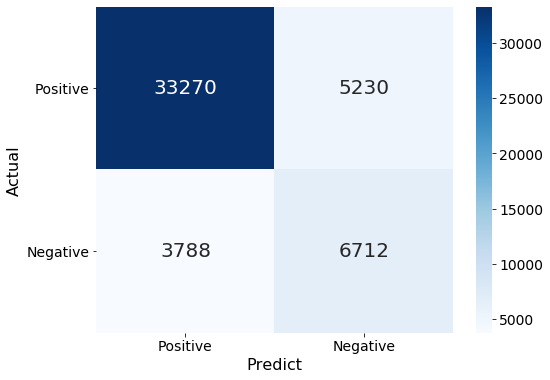

In [0]:
cm = confusion_matrix(y_test,y_preds[indx],labels=[1,0])
plot_confusion_matrix(cm)

In [0]:
lr_report=classification_report(y_test,y_preds[indx])
print(lr_report)

              precision    recall  f1-score   support

         0.0       0.56      0.64      0.60     10500
         1.0       0.90      0.86      0.88     38500

    accuracy                           0.82     49000
   macro avg       0.73      0.75      0.74     49000
weighted avg       0.83      0.82      0.82     49000



### Multinomial Bayes

In [0]:
alphas = [float("1e%d" %i) for i in range(-5,2)]
train_results = []
test_results = []
y_preds = []
for alpha in alphas:
  mnb = MultinomialNB(alpha=alpha)
  mnb.fit(X_train,y_train)
  train_results.append(mnb.score(X_train,y_train))
  y_preds.append(mnb.predict(X_test))
  test_results.append(mnb.score(X_test,y_test))

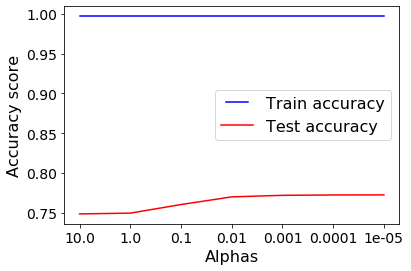

In [0]:
a = np.arange(len(alphas))
line1, = plt.plot(a, train_results, 'b', label='Train accuracy')
line2, = plt.plot(a, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax = plt.gca()
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(alphas)
ax.invert_xaxis()
plt.ylabel('Accuracy score')
plt.xlabel('Alphas')
plt.show()

In [0]:
indx = np.argmax(test_results)
best_accuracy = test_results[indx]
print('MNB best accuracy : ' + str(best_accuracy) 
  + ' with alpha = ' + str(alphas[indx]))

MNB best accuracy : 0.7726122448979592 with alpha = 1e-05


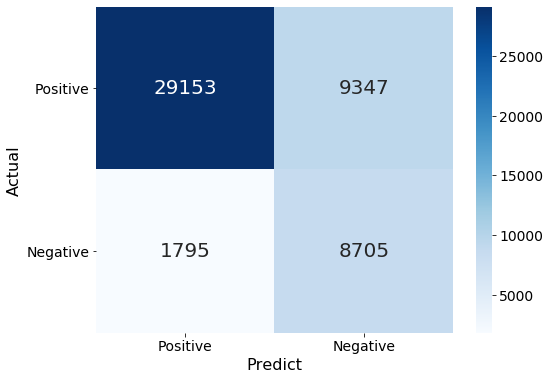

In [0]:
cm = confusion_matrix(y_test,y_preds[indx],labels=[1,0])
plot_confusion_matrix(cm)

In [0]:
mnb_report=classification_report(y_test,y_preds[indx])
print(mnb_report)

              precision    recall  f1-score   support

         0.0       0.48      0.83      0.61     10500
         1.0       0.94      0.76      0.84     38500

    accuracy                           0.77     49000
   macro avg       0.71      0.79      0.72     49000
weighted avg       0.84      0.77      0.79     49000



### SVM

In [0]:
Cs = [float("1e%d" %i) for i in range(-7,1)]
train_results = []
test_results = []
y_preds = []
for c in Cs:
  svm = LinearSVC(random_state=42,C=c,max_iter=5,verbose=3)
  svm.fit(X_train,y_train)
  train_results.append(svm.score(X_train,y_train))
  y_preds.append(svm.predict(X_test))
  test_results.append(svm.score(X_test,y_test))

[LibLinear][LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

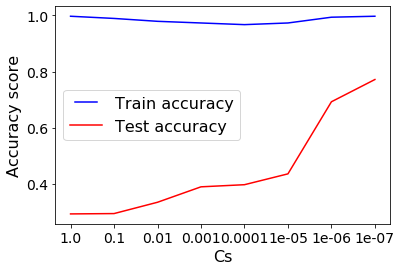

In [0]:
a = np.arange(len(Cs))
line1, = plt.plot(a, train_results, 'b', label='Train accuracy')
line2, = plt.plot(a, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax = plt.gca()
ax.xaxis.set_ticks(a)
ax.xaxis.set_ticklabels(Cs)
ax.invert_xaxis()
plt.ylabel('Accuracy score')
plt.xlabel('Cs')
plt.show()

In [0]:
indx = np.argmax(test_results)
best_accuracy = test_results[indx]
print('SVM best accuracy: ' + str(best_accuracy) 
  + ' with C = ' + str(Cs[indx]))

SVM best accuracy: 0.7714897959183673 with C = 1e-07


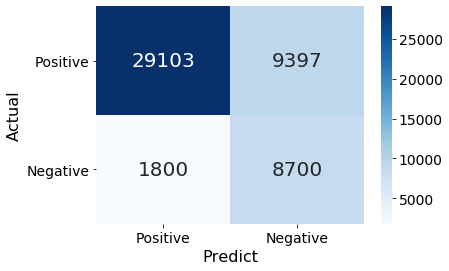

In [0]:
cm = confusion_matrix(y_test,y_preds[indx],labels=[1,0])
plot_confusion_matrix(cm)

In [0]:
svm_report=classification_report(y_test,y_preds[indx])
print(svm_report)

              precision    recall  f1-score   support

         0.0       0.48      0.83      0.61     10500
         1.0       0.94      0.76      0.84     38500

    accuracy                           0.77     49000
   macro avg       0.71      0.79      0.72     49000
weighted avg       0.84      0.77      0.79     49000



## Word2Vec Model

### Prepare data using Word2Vec

In [0]:
# %%time
# corpus = np.array(list(map(lambda x: x.split(), X_train)))
# bigrams = Phrases(sentences=corpus)

CPU times: user 51.8 s, sys: 1.2 s, total: 53 s
Wall time: 53 s


In [0]:
# %%time
# trigrams = Phrases(sentences=bigrams[corpus])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 2min 22s, sys: 52.5 ms, total: 2min 22s
Wall time: 2min 22s


In [0]:
# %%time
# embedding_vector_size = 256
# trigrams_model = Word2Vec(
#     sentences = trigrams[bigrams[corpus]],
#     size = embedding_vector_size,
#     min_count=3, window=5, workers=4)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 25min 25s, sys: 2.68 s, total: 25min 28s
Wall time: 21min 35s


In [0]:
# print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 87017


In [0]:
# !mkdir dv
# !mkdir ./drive/My\ Drive/data/dv
# trigrams_model.save('./dv/trigram.model')
# !cp -a ./dv/. ./drive/My\ Drive/data/dv
# !rm -r dv

mkdir: cannot create directory ‘./drive/My Drive/data/dv’: File exists


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#load trigrams model
input_length = 150
trigrams_model = Word2Vec.load('./drive/My Drive/data/dv/trigram.model')
print("Vocabulary size:", len(trigrams_model.wv.vocab))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Vocabulary size: 87017


In [0]:
def vectorize_data(data, vocab):
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    return vectorized

In [0]:
# %%time
# data = vectorize_data(trigrams[bigrams[corpus]], vocab=trigrams_model.wv.vocab)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 19min 57s, sys: 963 ms, total: 19min 58s
Wall time: 19min 58s


In [0]:
# %%time
# X_train = pad_sequences(
#     sequences=data,
#     maxlen=input_length,
#     padding='post')
# print('Transform sentences to sequences... (done)')

Transform sentences to sequences... (done)
CPU times: user 2.21 s, sys: 21.4 ms, total: 2.23 s
Wall time: 2.23 s


In [0]:
# %%time
# data_test = vectorize_data(trigrams[bigrams[np.array(list(map(lambda x: x.split(), X_test)))]], vocab=trigrams_model.wv.vocab)
# X_test = pad_sequences(
#     sequences=data_test,
#     maxlen=input_length,
#     padding='post')
# print('Transform sentences to sequences... (done)')

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Transform sentences to sequences... (done)
CPU times: user 3min 2s, sys: 147 ms, total: 3min 2s
Wall time: 3min 2s


In [0]:
np.save('X_train.npy',X_train)
!cp X_train.npy ./drive/My\ Drive/data/
!rm X_train.npy

In [0]:
np.save('X_test.npy',X_test)
!cp X_test.npy ./drive/My\ Drive/data/
!rm X_test.npy

### BiLSTM Model

Load prepared data

In [0]:
#load trigrams model
input_length = 150
trigrams_model = Word2Vec.load('./drive/My Drive/data/dv/trigram.model')
print("Vocabulary size:", len(trigrams_model.wv.vocab))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Vocabulary size: 87017


In [0]:
X_train = np.load('./drive/My Drive/data/X_train.npy')
X_test = np.load('./drive/My Drive/data/X_test.npy')

Build model

In [0]:
def build_model(embedding_matrix, input_length):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.15)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.35))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [0]:
model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 256)          22276352  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 22,449,025
Trainable params: 172,673
Non-trainable params: 22,276,352
____________________________________

In [0]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

In [0]:

batch_size = 150
epochs = 5
history = model.fit(
      x=X_train,
      y=y_train,
      validation_data=(X_test,y_test),
      batch_size=batch_size,
      epochs=epochs,
      use_multiprocessing=True)

Train on 300000 samples, validate on 49000 samples
Epoch 1/5
300000/300000 [==============================] - 1221s 4ms/step - loss: 0.3244 - acc: 0.8641 - val_loss: 0.2992 - val_acc: 0.8650
Epoch 2/5
300000/300000 [==============================] - 1201s 4ms/step - loss: 0.2472 - acc: 0.9015 - val_loss: 0.3031 - val_acc: 0.8718
Epoch 3/5
300000/300000 [==============================] - 1198s 4ms/step - loss: 0.2248 - acc: 0.9108 - val_loss: 0.2658 - val_acc: 0.8877
Epoch 4/5
300000/300000 [==============================] - 1197s 4ms/step - loss: 0.2104 - acc: 0.9173 - val_loss: 0.2403 - val_acc: 0.8978
Epoch 5/5
300000/300000 [==============================] - 1193s 4ms/step - loss: 0.1977 - acc: 0.9226 - val_loss: 0.2440 - val_acc: 0.9020


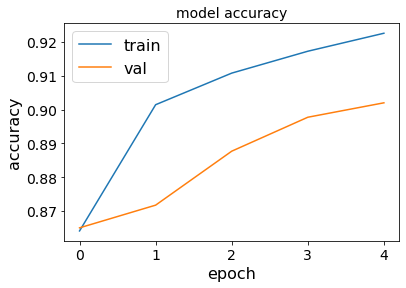

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
model.save('bilstm_2.h5')
!cp bilstm_2.h5 ./drive/My\ Drive/data
!rm bilstm_2.h5

In [0]:
model.evaluate(x=X_test,y=y_test,batch_size=100,use_multiprocessing=True)

49000/49000 [==============================] - 106s 2ms/step


[0.24403487913766686, 0.9020204095207915]

In [0]:
y_pred = model.predict_classes(x=X_test,batch_size=100)

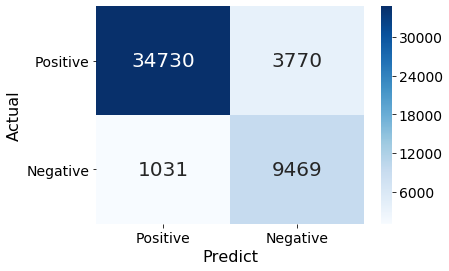

In [0]:
cm = confusion_matrix(y_test,y_pred,labels=[1,0])
plot_confusion_matrix(cm)

In [0]:
bilstm_report=classification_report(y_test,y_pred)
print(bilstm_report)

              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80     10500
         1.0       0.97      0.90      0.94     38500

    accuracy                           0.90     49000
   macro avg       0.84      0.90      0.87     49000
weighted avg       0.92      0.90      0.91     49000



In [7]:
#another bilstm model
model = load_model('./drive/My Drive/data/bilstm.h5')
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 256)          22276352  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_____________________________

In [15]:
model.evaluate(x=X_test,y=y_test,batch_size=100,use_multiprocessing=True)

49000/49000 [==============================] - 107s 2ms/step


[0.3287900553522061, 0.8924285723238575]